# Implementation of EfficientNetB3 for the APTOS 2019 competition with Keras

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In this kernel we will implement EfficientNet for medical images ([APTOS 2019](https://www.kaggle.com/c/aptos2019-blindness-detection) competition). EfficientNet was released this June (2019) by Google AI and is the new state-of-the-art on ImageNet. It introduces a systematic way to scale CNN (Convolutional Neural Networks) in a nearly optimal way. For this kernel we will use the B3 version, but feel free to play with the larger models. This kernel provides weights for EfficientNetB0 through B5. Weights for EfficientNetB6 and B7 can be found in [Google AI's repository for EfficientNet](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet). I highly recommend you to read [the EfficientNet paper](https://arxiv.org/pdf/1905.11946.pdf) as it signifies a fundamental shift in how the Deep Learning community will approach model scaling!

Also, check out this [video on EfficientNet by Henry AI Labs](https://youtu.be/3svIm5UC94I) for a clear explanation!

If you like this Kaggle kernel, feel free to give an upvote and leave a comment!

Image: an overview of model architectures and their performance on [ImageNet](http://www.image-net.org/). We can see that EfficientNet achieves state-of-the-art and uses a lot less parameters than most modern CNN architectures.

[Source: EfficientNet Paper](https://arxiv.org/pdf/1905.11946.pdf)

![](https://raw.githubusercontent.com/tensorflow/tpu/master/models/official/efficientnet/g3doc/params.png)

## Table Of Contents

- [Dependencies](#1)
- [Preparation](#2)
- [Metric (Quadratic Weighted Kappa)](#3)
- [EDA (Exploratory Data Analysis)](#4)
- [Preprocessing](#5)
- [Modeling (EfficientNetB3)](#6)
- [Evaluation](#7)
- [Submission](#8)

## Dependencies <a id="1"></a>

Special thanks to [qubvel](https://github.com/qubvel/efficientnet) for sharing an amazing wrapper to get the EfficientNet architecture in one line of code!

In [1]:
#!pip install git+https://github.com/qubvel/efficientnet

In [6]:
from keras_efficientnets import EfficientNetB0
import keras_efficientnets as efn 

Using TensorFlow backend.


In [7]:
import os
import sys
# Repository source: https://github.com/qubvel/efficientnet
sys.path.append(os.path.abspath('./input/efficientnet-keras/efficientnet-master/'))


In [8]:
from keras_efficientnets import EfficientNetB3

In [9]:
# Standard dependencies
import cv2
import time
import scipy as sp
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
from functools import partial
import matplotlib.pyplot as plt

# Machine Learning
import tensorflow as tf
from keras import backend as K
from keras.activations import elu
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.callbacks import Callback, ModelCheckpoint
from keras.layers import Dense, Conv2D, Flatten, GlobalAveragePooling2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import cohen_kappa_score

# Path specifications
KAGGLE_DIR = './input/'
TRAIN_DF_PATH = KAGGLE_DIR + "train.csv"
TEST_DF_PATH = KAGGLE_DIR + 'test.csv'
TRAIN_IMG_PATH = KAGGLE_DIR + "train_images/"
TEST_IMG_PATH = KAGGLE_DIR + 'test_images/'

# Specify title of our final model
SAVED_MODEL_NAME = 'effnet_modelB3.h5'

# Set seed for reproducability
seed = 1
np.random.seed(seed)
tf.set_random_seed(seed)

# For keeping time. GPU limit for this competition is set to ± 9 hours.
t_start = time.time()

# File sizes and specifications
print('\n# Files and file sizes')
for file in os.listdir(KAGGLE_DIR):
    print('{}| {} MB'.format(file.ljust(30), 
                             str(round(os.path.getsize(KAGGLE_DIR + file) / 1000000, 2))))


# Files and file sizes
train_images.zip              | 8602.0 MB
test_images                   | 0.07 MB
train_images                  | 0.13 MB
train.csv                     | 0.05 MB
sample_submission.csv         | 0.03 MB
test.csv                      | 0.03 MB
train_old                     | 0.0 MB


## Preparation <a id="2"></a>

By examining the data we can readily see that we do not have that much data (± 700 samples per class). It is probably a good idea to use data augmentation to increase robustness of our model (See the modeling section).

We could also try to use additional data from previous competitions to increase performance. Although I do not implement this in the kernel, feel free to experiment with adding data. Additional data can be found in [this Kaggle dataset](https://www.kaggle.com/benjaminwarner/resized-2015-2019-blindness-detection-images) (± 35000 additional images).

In [10]:
print("Image IDs and Labels (TRAIN)")
train_df = pd.read_csv(TRAIN_DF_PATH)

# Add extension to id_code
train_df['id_code'] = train_df['id_code'] + ".png"
print(f"Training images: {train_df.shape[0]}")
display(train_df.head())
print("Image IDs (TEST)")
test_df = pd.read_csv(TEST_DF_PATH)

# Add extension to id_code
test_df['id_code'] = test_df['id_code'] + ".png"
print(f"Testing Images: {test_df.shape[0]}")
display(test_df.head())

Image IDs and Labels (TRAIN)
Training images: 3662


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


Image IDs (TEST)
Testing Images: 1928


,id_code
0,0005cfc8afb6.png
1,003f0afdcd15.png
2,006efc72b638.png
3,00836aaacf06.png
4,009245722fa4.png


We will use the original images size from the [EfficientNet paper](https://arxiv.org/pdf/1905.11946.pdf). For EfficientNetB3 this is 300x300x3. The original image sizes used for every version of EfficientNet are:

- EfficientNetB0 - (224, 224, 3)
- EfficientNetB1 - (240, 240, 3)
- EfficientNetB2 - (260, 260, 3)
- **EfficientNetB3 - (300, 300, 3)**
- EfficientNetB4 - (380, 380, 3)
- EfficientNetB5 - (456, 456, 3)
- EfficientNetB6 - (528, 528, 3)
- EfficientNetB7 - (600, 600, 3)


In [11]:
# Specify image size
IMG_WIDTH = 300
IMG_HEIGHT = 300
CHANNELS = 3

## Metric (Quadratic Weighted Kappa) <a id="3"></a>

The metric that is used for this competition is Quadratic Weighted Kappa (QWK) ([Kaggle's Explanation](https://www.kaggle.com/c/aptos2019-blindness-detection/overview/evaluation)) 

The formula for weighted kappa is:

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/2a496e1cef7d812b83bdbb725d291748cf0183f5)

In this case we are going to optimize Mean Squared Error (MSE) (See Modeling section) since we are using regression and by optimizing MSE we are also optimizing QWK as long as we round predictions afterwards. Additionally we are going to same the model which achieves the best QWK score on the validation data through a custom Keras Callback.

For a more detailed and practical explanation of QWK I highly recommend [this Kaggle kernel](https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps).

In [12]:
def get_preds_and_labels(model, generator):
    """
    Get predictions and labels from the generator
    """
    preds = []
    labels = []
    for _ in range(int(np.ceil(generator.samples / BATCH_SIZE))):
        x, y = next(generator)
        preds.append(model.predict(x))
        labels.append(y)
    # Flatten list of numpy arrays
    return np.concatenate(preds).ravel(), np.concatenate(labels).ravel()

In [13]:
class Metrics(Callback):
    """
    A custom Keras callback for saving the best model
    according to the Quadratic Weighted Kappa (QWK) metric
    """
    def on_train_begin(self, logs={}):
        """
        Initialize list of QWK scores on validation data
        """
        self.val_kappas = []

    def on_epoch_end(self, epoch, logs={}):
        """
        Gets QWK score on the validation data
        and saves the model if the score is better
        than previous epochs
        """
        # Get predictions and convert to integers
        y_pred, labels = get_preds_and_labels(model, val_generator)
        y_pred = np.rint(y_pred).astype(np.uint8).clip(0, 4)
        # We can use sklearns implementation of QWK straight out of the box
        # as long as we specify weights as 'quadratic'
        _val_kappa = cohen_kappa_score(labels, y_pred, weights='quadratic')
        self.val_kappas.append(_val_kappa)
        print(f"val_kappa: {_val_kappa:.4f}")
        
        # Save best model
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save(SAVED_MODEL_NAME)
        return

## EDA (Exploratory Data Analysis) <a id="4"></a>

For EDA on image datasets I think one should at least examine the label distribution, the images before preprocessing and the images after preprocessing. Through examining these three aspects we can get a good sense of the problem. Note that the distribution on the test set can still vary wildly from the training data.

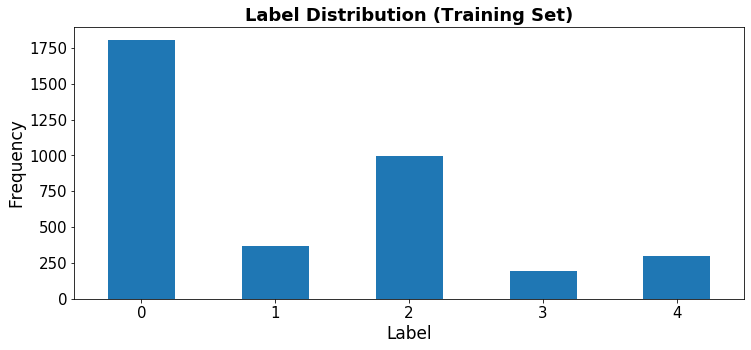

In [14]:
# Label distribution
train_df['diagnosis'].value_counts().sort_index().plot(kind="bar", 
                                                       figsize=(12,5), 
                                                       rot=0)
plt.title("Label Distribution (Training Set)", 
          weight='bold', 
          fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel("Label", fontsize=17)
plt.ylabel("Frequency", fontsize=17);

We will visualize a random image from every label to get a general sense of the distinctive features that seperate the classes. We will take this into account and try to enhance these features in our preprocessing. For these images there some to be increasingly more spots and stains on the retina as diabetic retinopathy worsens.

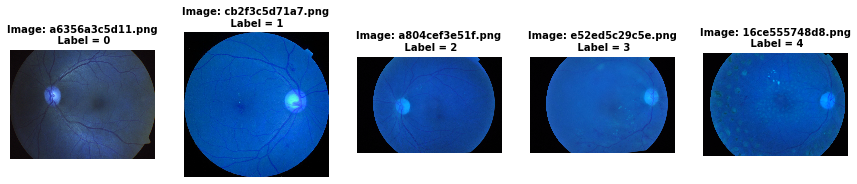

In [15]:
# Example from every label
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = cv2.imread(f"{TRAIN_IMG_PATH}{image_name}")
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

## Preprocessing <a id="5"></a>

Here we will use the auto-cropping method with Ben's preprocessing as explained in [this kernel](https://www.kaggle.com/ratthachat/aptos-updatedv14-preprocessing-ben-s-cropping).

In [16]:
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and 
    returns the a preprocessed image with 
    3 channels
    """
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(path, sigmaX=10):
    """
    The whole preprocessing pipeline:
    1. Read in image
    2. Apply masks
    3. Resize image to desired size
    4. Add Gaussian noise to increase Robustness
    """
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image

After preprocessing we have managed to enhance the distinctive features in the images. This will increase performance when we train our EfficientNet model.

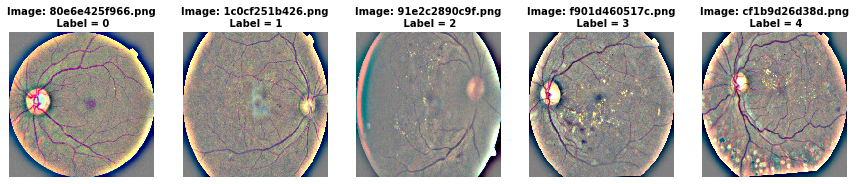

In [13]:
# Example of preprocessed images from every label
fig, ax = plt.subplots(1, 5, figsize=(15, 6))
for i in range(5):
    sample = train_df[train_df['diagnosis'] == i].sample(1)
    image_name = sample['id_code'].item()
    X = preprocess_image(f"{TRAIN_IMG_PATH}{image_name}")
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", 
                    weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X);

In [14]:
# Labels for training data
y_labels = train_df['diagnosis'].values

## Modeling (EfficientNetB3) <a id="6"></a>

Since we want to optimize the Quadratic Weighted Kappa score we can formulate this challenge as a regression problem. In this way we are more flexible in our optimization and we can yield higher scores than solely optimizing for accuracy. We will optimize a pre-trained EfficientNetB3 with a few added layers. The metric that we try to optimize is the [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error). This is the mean of squared differences between our predictions and labels, as showed in the formula below. By optimizing this metric we are also optimizing for Quadratic Weighted Kappa if we round the predictions afterwards.

![](https://study.com/cimages/multimages/16/4e7cf150-0179-4d89-86f2-5cbb1f51c266_meansquarederrorformula.png)

Since we are not provided with that much data (3662 images), we will augment the data to make the model more robust. We will rotate the data on any angle. Also, we will flip the data both horizontally and vertically. Lastly, we will divide the data by 128 for normalization.

In [18]:
BATCH_SIZE = 16

# Add Image augmentation to our generator
train_datagen = ImageDataGenerator(rotation_range=360,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   validation_split=0.15,
                                   rescale=1 / 128)

# Use the dataframe to define train and validation generators
train_generator = train_datagen.flow_from_dataframe(train_df, 
                                                    x_col='id_code', 
                                                    y_col='diagnosis',
                                                    directory = TRAIN_IMG_PATH,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='other',
                                                    preprocessing_function=preprocess_image, 
                                                    subset='training')

val_generator = train_datagen.flow_from_dataframe(train_df, 
                                                  x_col='id_code', 
                                                  y_col='diagnosis',
                                                  directory = TRAIN_IMG_PATH,
                                                  target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                  batch_size=BATCH_SIZE,
                                                  class_mode='other',
                                                  preprocessing_function=preprocess_image, 
                                                  subset='validation')

Found 3113 validated image filenames.
Found 549 validated image filenames.


Thanks to the amazing wrapper by [qubvel](https://github.com/qubvel/efficientnet) we can load in a model like the Keras API. We specify the input shape and that we want the model without the top (the final Dense layer). Then we load in the weights which are provided in [this Kaggle dataset](https://www.kaggle.com/ratthachat/efficientnet-keras-weights-b0b5).

In [19]:
# Load in EfficientNetB3
effnet = EfficientNetB3(weights=None,
                        include_top=False,
                        input_shape=(IMG_WIDTH, IMG_HEIGHT, CHANNELS))
effnet.load_weights('./efficientnet-keras/efficientnet-keras-weights/efficientnet-b3_imagenet_1000_notop.h5')

def build_model(learning_rate):
    """
    A custom implementation of EfficientNetB3
    for the APTOS 2019 competition
    (Regression with 5 classes)
    """
    model = Sequential()
    model.add(effnet)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(5, activation=elu))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mse',
                  optimizer=Adam(learning_rate), 
                  metrics=['mse', 'acc'])
    print(model.summary())
    return model

# Initialize our model
learning_rate = 0.00005
model = build_model(learning_rate)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 10, 10, 1536)      10783528  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1536)              0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 7685      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 6         
Total params: 10,791,219
Trainable params: 10,703,923
Non-trainable params: 87,296
_________________________________________________________________
None


In the first training phase we only train the top layer and freeze the pre-trained model. This is the traditional transfer learning approach were we can optimize and model fast for almost any image content. Since the pre-trained model was trained on [ImageNet](http://www.image-net.org/) and not on medical images, there are some limitations to this approach for out challenge. We will try to counter those limitations by adding a second training phase.

After each epoch we save the model if it is better than the previous one, according to the Quadratic Weighted Kappa score on the validation set. We also monitor the Mean Squared Error and stop training if it does not improve for 2 epochs. This way we can counter overfitting through monitoring Quadratic Weighted Kappa and Mean Squared Error.

Another option we could use is to directly use Quadratic Weighted Kappa as a loss function. Feel free to experiment with this. An implementation of a [QWK loss function for Tensorflow/Keras can be found in this Kaggle kernel](https://www.kaggle.com/christofhenkel/weighted-kappa-loss-for-keras-tensorflow).

In [20]:
# For tracking Quadratic Weighted Kappa score and saving best weights
kappa_metrics = Metrics()
# Monitor MSE to avoid overfitting
es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=5)

# First training phase (train top layer)
model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=15,
                    workers=8, 
                    use_multiprocessing=True,                    
                    validation_data=val_generator,
                    validation_steps = val_generator.samples // BATCH_SIZE,
                    callbacks=[kappa_metrics, es])

Epoch 1/15


/home/oscar/anaconda3/lib/python3.7/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


194/194 [==============================] - 102s 523ms/step - loss: 0.7122 - mean_squared_error: 0.7122 - acc: 0.5577 - val_loss: 0.7317 - val_mean_squared_error: 0.7317 - val_acc: 0.5349
val_kappa: 0.4492
Validation Kappa has improved. Saving model.
Epoch 2/15
194/194 [==============================] - 78s 402ms/step - loss: 0.4753 - mean_squared_error: 0.4753 - acc: 0.6234 - val_loss: 0.5907 - val_mean_squared_error: 0.5907 - val_acc: 0.5993
val_kappa: 0.4871
Validation Kappa has improved. Saving model.
Epoch 3/15
194/194 [==============================] - 78s 403ms/step - loss: 0.4789 - mean_squared_error: 0.4789 - acc: 0.6070 - val_loss: 0.9765 - val_mean_squared_error: 0.9765 - val_acc: 0.5956
val_kappa: 0.5889
Validation Kappa has improved. Saving model.
Epoch 4/15
194/194 [==============================] - 78s 403ms/step - loss: 0.4719 - mean_squared_error: 0.4719 - acc: 0.6495 - val_loss: 0.5395 - val_mean_squared_error: 0.5395 - val_acc: 0.6949
val_kappa: 0.7485
Validation Kapp

In [ ]:
# Visualize mse for first training phase
history_df = pd.DataFrame(model.history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE) for first training phase", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['acc', 'val_acc']].plot(figsize=(12,5))
plt.title("Accuracy for first training phase", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");

In the second training phase we unfreeze all layers a fine-tune all layers of the model. This allows us to benefit from the pre-training on [ImageNet](http://www.image-net.org/) and optimize the model for our medical data. We will use a lower learning rate for this training phase.

In [16]:
# Unfreeze layers and fine-tune model
for layer in model.layers:
    layer.trainable = True

# Start second training phase (fine-tune all layers)
model.fit_generator(train_generator,
                    steps_per_epoch=train_generator.samples // BATCH_SIZE,
                    epochs=25,
                    validation_data=val_generator,
                    validation_steps=val_generator.samples // BATCH_SIZE,
                    callbacks=[kappa_metrics, es])

Epoch 1/25
97/97 [==============================] - 436s 4s/step - loss: 0.2824 - mean_squared_error: 0.2824 - acc: 0.7698 - val_loss: 0.2954 - val_mean_squared_error: 0.2954 - val_acc: 0.7524
val_kappa: 0.8585
Validation Kappa has improved. Saving model.
Epoch 2/25
97/97 [==============================] - 376s 4s/step - loss: 0.2591 - mean_squared_error: 0.2591 - acc: 0.7656 - val_loss: 0.3491 - val_mean_squared_error: 0.3491 - val_acc: 0.7389
val_kappa: 0.8629
Validation Kappa has improved. Saving model.
Epoch 3/25
97/97 [==============================] - 377s 4s/step - loss: 0.2621 - mean_squared_error: 0.2621 - acc: 0.7664 - val_loss: 0.2885 - val_mean_squared_error: 0.2885 - val_acc: 0.7756
val_kappa: 0.8986
Validation Kappa has improved. Saving model.
Epoch 4/25
97/97 [==============================] - 379s 4s/step - loss: 0.2504 - mean_squared_error: 0.2504 - acc: 0.7754 - val_loss: 0.3036 - val_mean_squared_error: 0.3036 - val_acc: 0.7482
val_kappa: 0.8648
Epoch 5/25
97/97 [===

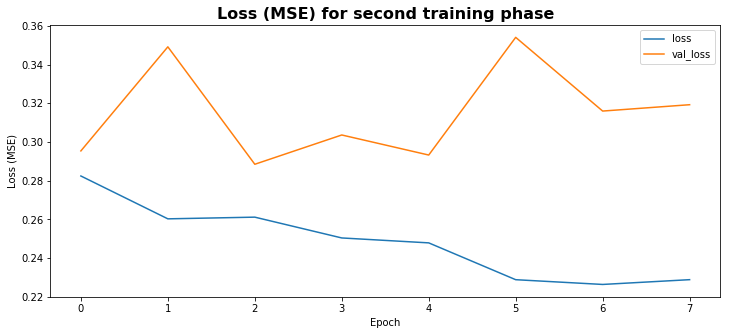

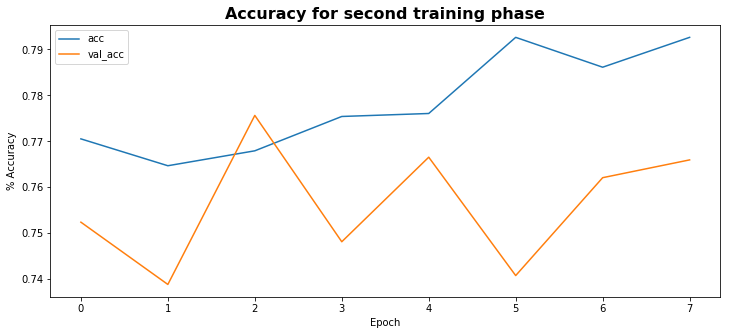

In [17]:
# Visualize MSE for second training phase
history_df = pd.DataFrame(model.history.history)
history_df[['loss', 'val_loss']].plot(figsize=(12,5))
plt.title("Loss (MSE) for second training phase", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
history_df[['acc', 'val_acc']].plot(figsize=(12,5))
plt.title("Accuracy for second training phase", fontsize=16, weight='bold')
plt.xlabel("Epoch")
plt.ylabel("% Accuracy");

## Evaluation <a id="7"></a>

In [18]:
# Load best weights according to validation kappa score
model.load_weights(SAVED_MODEL_NAME)

To evaluate our performance we predict values from the generator and round them of to the nearest integer to get valid predictions. After that we calculate the Quadratic Weighted Kappa score on the training set and the validation set.

In [19]:
# Calculate QWK on train set
y_train_preds, train_labels = get_preds_and_labels(model, train_generator)
y_train_preds = np.rint(y_train_preds).astype(np.uint8).clip(0, 4)

# Calculate score
train_score = cohen_kappa_score(train_labels, y_train_preds, weights="quadratic")

# Calculate QWK on validation set
y_val_preds, val_labels = get_preds_and_labels(model, val_generator)
y_val_preds = np.rint(y_val_preds).astype(np.uint8).clip(0, 4)

# Calculate score
val_score = cohen_kappa_score(val_labels, y_val_preds, weights="quadratic")

In [20]:
print(f"The Training Cohen Kappa Score is: {round(train_score, 5)}")
print(f"The Validation Cohen Kappa Score is: {round(val_score, 5)}")

The Training Cohen Kappa Score is: 0.94548
The Validation Cohen Kappa Score is: 0.88803


We can optimize the validation score by doing a [Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) over rounding thresholds instead of doing "normal" rounding. The "OptimizedRounder" class by [Abhishek Thakur](https://www.kaggle.com/abhishek) is a great way to do this. The original class can be found in [this Kaggle kernel](https://www.kaggle.com/abhishek/optimizer-for-quadratic-weighted-kappa).

In [21]:
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa score
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4

        ll = cohen_kappa_score(y, X_p, weights='quadratic')
        return -ll

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        """
        X_p = np.copy(X)
        for i, pred in enumerate(X_p):
            if pred < coef[0]:
                X_p[i] = 0
            elif pred >= coef[0] and pred < coef[1]:
                X_p[i] = 1
            elif pred >= coef[1] and pred < coef[2]:
                X_p[i] = 2
            elif pred >= coef[2] and pred < coef[3]:
                X_p[i] = 3
            else:
                X_p[i] = 4
        return X_p

    def coefficients(self):
        return self.coef_['x']

In [22]:
# Optimize on validation data and evaluate again
y_val_preds, val_labels = get_preds_and_labels(model, val_generator)
optR = OptimizedRounder()
optR.fit(y_val_preds, val_labels)
coefficients = optR.coefficients()
opt_val_predictions = optR.predict(y_val_preds, coefficients)
new_val_score = cohen_kappa_score(val_labels, opt_val_predictions, weights="quadratic")

In [23]:
print(f"Optimized Thresholds:\n{coefficients}\n")
print(f"The Validation Quadratic Weighted Kappa (QWK)\n\
with optimized rounding thresholds is: {round(new_val_score, 5)}\n")
print(f"This is an improvement of {round(new_val_score - val_score, 5)}\n\
over the unoptimized rounding")

Optimized Thresholds:
[0.52351008 1.35186251 2.60345013 3.41304268]

The Validation Quadratic Weighted Kappa (QWK)
with optimized rounding thresholds is: 0.89691

This is an improvement of 0.00888
over the unoptimized rounding


## Submission <a id="8"></a>

We will create one last generator for the test data to make our final predictions.

In [24]:
# Place holder for diagnosis column
test_df['diagnosis'] = np.zeros(test_df.shape[0]) 
# For preprocessing test images
test_generator = ImageDataGenerator(rescale=1 / 128).flow_from_dataframe(test_df, 
                                                    x_col='id_code', 
                                                    y_col = 'diagnosis',
                                                    directory = TEST_IMG_PATH,
                                                    target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size=BATCH_SIZE,
                                                    class_mode='other',
                                                    preprocessing_function=preprocess_image)

Found 1928 validated image filenames.


As mentioned earlier, we use custom thresholds to optimize our score. The same thresholds should be used when creating the final predictions.

In [25]:
# Make final predictions, round predictions and save to csv
y_test, _ = get_preds_and_labels(model, test_generator)
y_test = optR.predict(y_test, coefficients).astype(np.uint8)
test_df['diagnosis'] = y_test
test_df.to_csv('submission.csv', index=False)

After creating the submission I always check the format and the distribution of the test predictions. Do they makes sense given the label distribution of the training data?

In [26]:
# Check submission and distribution of predictions
print("Submission File")
display(test_df.head())
print("Prediction Distribution:")
test_df['diagnosis'].value_counts()

Submission File


,id_code,diagnosis
0,0005cfc8afb6.png,2
1,003f0afdcd15.png,0
2,006efc72b638.png,1
3,00836aaacf06.png,1
4,009245722fa4.png,0


Prediction Distribution:


2    975
0    369
1    314
3    225
4     45
Name: diagnosis, dtype: int64

In [27]:
# Check kernels run-time. GPU limit for this competition is set to ± 9 hours.
t_finish = time.time()
total_time = round((t_finish-t_start) / 3600, 4)
print('Kernel runtime = {} hours ({} minutes)'.format(total_time, 
                                                      int(total_time*60)))

Kernel runtime = 3.3575 hours (201 minutes)


That's it! Feel free to experiment with this kernel and try a larger implementation of EfficientNet. This kernel provides weights for EfficientNetB0 through B5. Weights for EfficientNetB6 and B7 can be found in [Google AI's repository for EfficientNet](https://github.com/tensorflow/tpu/tree/master/models/official/efficientnet).

**If you like this Kaggle kernel, feel free to give an upvote and leave a comment! I will try to implement your suggestions in this kernel!**